In [1]:
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

import itertools as it
import time

from ner import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [2]:
#tok_to_id, glv_emb = load_emb('data/glove/glove.6B.100d.txt', int(4e5))
#torch.save((tok_to_id, glv_emb), 'data/pt-cache/tok_to_id__glv_emb.pt')
tok_to_id, glv_emb = torch.load('data/pt-cache/tok_to_id__glv_emb.pt')

In [3]:
#chr_to_id = load_chrs('data/ner-gmb/train.txt')
#torch.save(chr_to_id, 'data/pt-cache/chr_to_id.pt')
chr_to_id = torch.load('data/pt-cache/chr_to_id.pt')

In [4]:
#lbl_to_id, id_to_lbl = load_classes('data/ner-gmb/train.txt')
#torch.save((lbl_to_id, id_to_lbl), 'data/pt-cache/lbl_to_id__id_to_lbl')
lbl_to_id, id_to_lbl = torch.load('data/pt-cache/lbl_to_id__id_to_lbl')

In [5]:
#train_W, train_X, train_Y = load_data('data/ner-gmb/train.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((train_W, train_X, train_Y), 'data/pt-cache/train_W__train_X__train_Y.pt')
train_W, train_X, train_Y = torch.load('data/pt-cache/train_W__train_X__train_Y.pt')

In [6]:
#dev_W, dev_X, dev_Y = load_data('data/ner-gmb/dev.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((dev_W, dev_X, dev_Y), 'data/pt-cache/dev_W__dev_X__dev_Y.pt')
dev_W, dev_X, dev_Y = torch.load('data/pt-cache/dev_W__dev_X__dev_Y.pt')

In [7]:
#test_W, test_X, test_Y = load_data('data/ner-gmb/test.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((test_W, test_X, test_Y), 'data/pt-cache/test_W__test_X__test_Y.pt')
test_W, test_X, test_Y = torch.load('data/pt-cache/test_W__test_X__test_Y.pt')

In [8]:
train_W = train_W.to(device)
train_X = train_X.to(device)
train_Y = train_Y.to(device)

In [9]:
dev_W = dev_W.to(device)
dev_X = dev_X.to(device)
dev_Y = dev_Y.to(device)

In [10]:
test_W = test_W.to(device)
test_X = test_X.to(device)
test_Y = test_Y.to(device)

In [19]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
rand_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=torch.randn(len(tok_to_id), 100),
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5,
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK']
)
#rand_model.load_state_dict(torch.load('data/pt-cache/rand_model.pt'))

In [20]:
train_losses, train_metrics, dev_losses, dev_metrics = train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=rand_model.to(device),
    opt=optim.Adam(rand_model.parameters(), lr=0.1),
    n_classes=len(lbl_to_id)-1,
    train_batch_size=128,
    dev_batch_size=128,
    grad_clip_norm=5,
    patience=1,
    show=False
)

In [21]:
torch.save(rand_model.state_dict(), 'data/pt-cache/rand_model.pt')

In [22]:
test_pred = rand_model.to(device).batch_predict(test_W, test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

/home/cse/btech/cs1180416/.local/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00       102
         eve       0.52      0.25      0.34        87
         geo       0.70      0.78      0.74      9912
         gpe       0.81      0.82      0.82      4168
         nat       0.27      0.05      0.09        55
         org       0.41      0.44      0.42      5205
         per       0.56      0.55      0.55      4406
         tim       0.77      0.76      0.77      5275

   micro avg       0.65      0.68      0.67     29210
   macro avg       0.51      0.46      0.47     29210
weighted avg       0.65      0.68      0.66     29210



In [23]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#glv_model.load_state_dict(torch.load('data/pt-cache/glv_model.pt'))

TypeError: __init__() got an unexpected keyword argument 'class_freq'

In [ ]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=glv_model.to(device),
    opt=optim.Adam(glv_model.parameters(), lr=0.01),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)

In [ ]:
torch.save(glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [ ]:
test_pred = glv_model.to(device).batch_predict(test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

In [2]:
chr_glv_model = NERModel(
    embed_model=ChrTokEmbModel(
        chr_emb_model=ChrEmbModel(
            n_embs=len(chr_to_id),
            pad_chr_id=chr_to_id['PAD_CHR'],
            emb_size=8,
            hidden_size=25
        ),
        tok_emb_model=nn.Embedding.from_pretrained(
            glv_emb,
            freeze=False,
            padding_idx=tok_to_id['PAD_TOK']
        )
    ),
    seq_tag_model=SeqTagModel(
        input_size=150,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#chr_glv_model.load_state_dict(torch.load('data/pt-cache/chr_glv_model.pt'))

NameError: name 'NERModel' is not defined

In [ ]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=chr_glv_model.to(device),
    opt=optim.Adam(chr_glv_model.parameters(), lr=0.001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=2048,
    grad_clip_norm=5
)

In [ ]:
torch.save(chr_glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [ ]:
test_pred = chr_glv_model.to(device).batch_predict(test_W, test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

In [8]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
ln_glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=LNSeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#ln_glv_model.load_state_dict(torch.load('data/pt-cache/ln_glv_model.pt'))

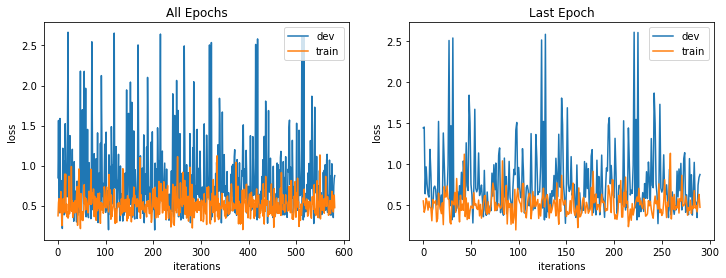

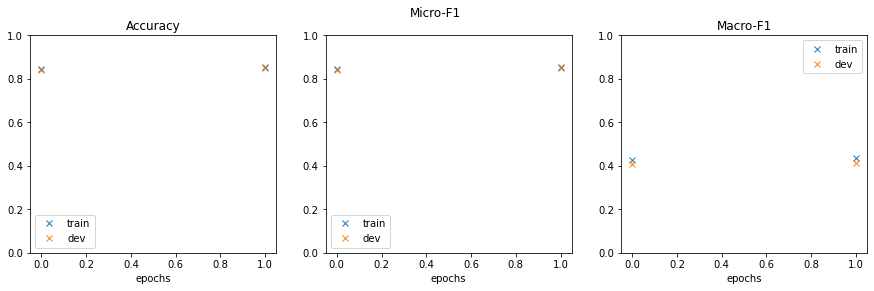

0.4750710129737854
0.8744432926177979


KeyboardInterrupt: 

In [20]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=ln_glv_model.to(device),
    opt=optim.Adam(ln_glv_model.parameters(), lr=0.0001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)

In [21]:
torch.save(ln_glv_model.state_dict(), 'data/pt-cache/ln_glv_model.pt')

In [22]:
test_pred = ln_glv_model.to(device).batch_predict(test_W, test_X, 4096)

In [23]:
tic = time.time()
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))
toc = time.time()
print(toc-tic)

              precision    recall  f1-score   support

         art       0.01      0.32      0.02       102
         eve       0.04      0.52      0.07        87
         geo       0.60      0.79      0.68      9912
         gpe       0.78      0.87      0.82      4168
         nat       0.04      0.58      0.07        55
         org       0.24      0.44      0.31      5205
         per       0.55      0.74      0.63      4406
         tim       0.24      0.49      0.32      5275

   micro avg       0.40      0.67      0.50     29210
   macro avg       0.31      0.59      0.37     29210
weighted avg       0.48      0.67      0.56     29210

11.826610326766968


In [33]:
ln_chr_glv_model = NERModel(
    embed_model=ChrTokEmbModel(
        chr_emb_model=ChrEmbModel(
            n_embs=len(chr_to_id),
            pad_chr_id=chr_to_id['PAD_CHR'],
            emb_size=16,
            hidden_size=25,
            unk_chr_id=chr_to_id['UNK_CHR'],
            unk_replace_prob=0.5
        ),
        tok_emb_model=nn.Embedding.from_pretrained(
            glv_emb,
            freeze=False,
            padding_idx=tok_to_id['PAD_TOK']
        )
    ),
    seq_tag_model=LNSeqTagModel(
        input_size=150,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK']
)
#ln_chr_glv_model.load_state_dict(torch.load('data/pt-cache/ln_chr_glv_model.pt'))

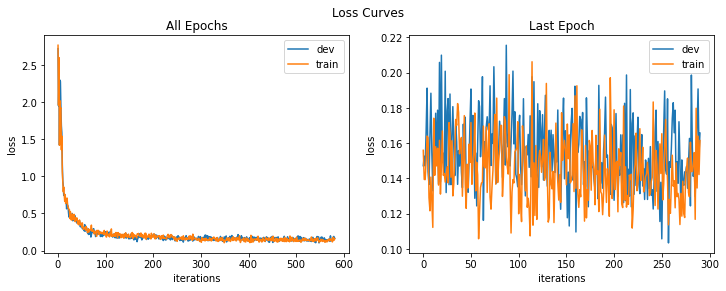

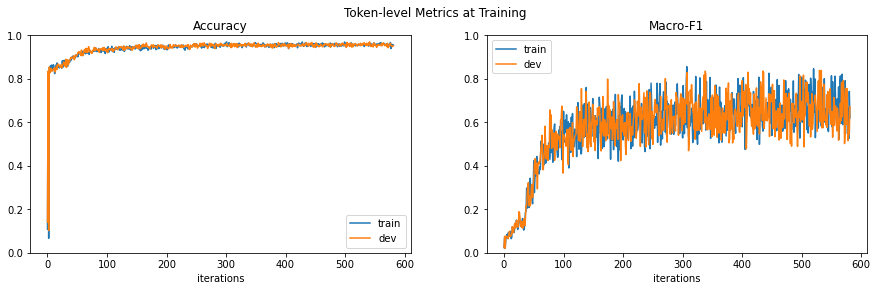

KeyboardInterrupt: 

In [34]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=ln_chr_glv_model.to(device),
    opt=optim.Adam(ln_chr_glv_model.parameters(), lr=0.1),
    n_classes=len(lbl_to_id)-1,
    train_batch_size=128,
    dev_batch_size=128,
    grad_clip_norm=5,
    patience=3,
    show=True
)

In [35]:
torch.save(ln_chr_glv_model.state_dict(), 'data/pt-cache/ln_chr_glv_model.pt')

In [36]:
test_pred = ln_chr_glv_model.to(device).batch_predict(test_W, test_X, 4096)

In [37]:
tic = time.time()
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))
toc = time.time()
print(toc-tic)

              precision    recall  f1-score   support

         art       0.60      0.03      0.06       102
         eve       0.45      0.31      0.37        87
         geo       0.79      0.84      0.82      9912
         gpe       0.88      0.88      0.88      4168
         nat       0.56      0.09      0.16        55
         org       0.58      0.54      0.56      5205
         per       0.69      0.76      0.73      4406
         tim       0.81      0.79      0.80      5275

   micro avg       0.76      0.77      0.76     29210
   macro avg       0.67      0.53      0.54     29210
weighted avg       0.75      0.77      0.76     29210

16.203941106796265
